## curvityCoverage.ipynb
This notebook provides interactive visualizations of curvity-driven swarm behavior. It loads simulation data, converts it into a format suitable for animation, and shows how particles explore their environment over time. Key tools include:

- Coverage tracking using a spatial grid
- Animated swarm motion in circular or rectangular arenas
- Particle coloring by curvity type (fronters, weak/medium/strong aligners)
- Detection of when a desired coverage threshold is reached

The notebook helps intuitively understand the dynamics and efficiency of different swarm configurations.

In [15]:
import pickle
import time
import pdb
import os
import random
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import trackpy as tp
import ecoSystem as es

from matplotlib.patches import Rectangle, Circle
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter, HTMLWriter
from matplotlib.lines import Line2D
from os import listdir
from os.path import isfile, join
from scipy.optimize import curve_fit

In [2]:
def loadMultipleFiles(params,N,T,folderName):
    """
    Loads and stacks multiple pickled simulation files from a folder.

    Each file is assumed to contain an array of shape [T, params, N].

    Returns:
        SPall: Combined array of shape [T × num_files, params, N]
    """
    onlyfiles = [f for f in listdir(folderName) if isfile(join(folderName, f))]
    onlyfiles.sort()
    Nfiles = len(onlyfiles)

    SPall = np.zeros((T*Nfiles,params,N))

    for i in range(Nfiles):
        fileName = onlyfiles[i]
        SPall[T*i:T*(i+1):,:] = pickle.load(open(folderName+'/'+fileName,"rb"))
        
    return SPall

def unfoldTorus(x,boxSize):
    """
    Unwraps 1D trajectory x across periodic boundaries of size boxSize.

    Returns:
        Unwrapped trajectory with large jumps corrected.
    """
    dx = np.diff(x)
    dxs = (1*(np.abs(dx)>=boxSize*0.9))*np.sign(dx)*boxSize
    dxc = np.cumsum(dxs)
    x[1:] -= dxc
    return x

In [3]:
def to_trackpy_dataframe(particles):
    """
    Converts simulation output array [T, param, N] to a trackpy-compatible DataFrame.

    Args:
        particles (np.ndarray): Simulation data of shape [T, params, N]

    Returns:
        pd.DataFrame: DataFrame with columns ['particle', 'x', 'y', 'frame']
    """
    part_df = pd.DataFrame(columns=["particle", "x", "y", "frame"])
    
    T = particles.shape[0]
    nr_particles = particles.shape[2]
    part_range = np.arange(0, nr_particles)
    
    # initialize all arrays
    xs = np.zeros(T * nr_particles)
    ys = np.zeros(T * nr_particles)
    frames = np.zeros(T * nr_particles)
    particle_nr = np.zeros(T * nr_particles)
    
    # fill arrays
    for t in range(T):
        particle_nr[t*nr_particles: (t+1)*nr_particles] = part_range
        xs[t*nr_particles: (t+1)*nr_particles] = particles[t, eco.xC, :] 
        ys[t*nr_particles: (t+1)*nr_particles] = particles[t, eco.yC, :]  
        frames[t*nr_particles: (t+1)*nr_particles] = int(t)
    
    # set arrays do df columns
    part_df["particle"] = particle_nr
    part_df["x"] = xs.astype(np.float32)
    part_df["y"] = ys.astype(np.float32)
    part_df["frame"] = frames

    return part_df

In [4]:
# Hyperparameters
N = 100
T = 1000
params = 8
boxsize = 5 
fps = 1
mpp = 1
max_lagtime = 3000

# Set up ecosystem object
eco = es.ecoSystem(N=N, params=params)

# Base directory containing the result folders
base_dir = "test"
# Get all result folders (1st-level only)
for root, dirs, files in os.walk(base_dir):
    folder_names = dirs
    break


In [5]:
df_list = []
df_number = 0

for i, folder in enumerate(folder_names):
    full_dir = os.path.join(base_dir, folder)
    SPall = loadMultipleFiles(params, N, T, full_dir)
    print(len(SPall))
    SPall = SPall[1:, :, :]
    part_df = to_trackpy_dataframe(SPall)
    kappa_per_particle = SPall[0, eco.wAC, :]
    part_df["kappa"] = part_df["particle"].map(lambda pid: kappa_per_particle[int(pid)])
    a = SPall[0, eco.rStericC, 0]  
    part_df["a"] = a
    part_df["kappa_a"] = part_df["kappa"] * a

    part_df["df_number"] = df_number
    df_number += 1

    df_list.append(part_df)

# Concatenate all DataFrames
full_df = pd.concat(df_list, ignore_index=True)

10000


In [6]:
full_df.tail()

,particle,x,y,frame,kappa,a,kappa_a,df_number
999895,95.0,0.052645,2.368270,9998.0,-10.0,0.05,-0.5,0
999896,96.0,0.390470,1.764550,9998.0,10.0,0.05,0.5,0
999897,97.0,0.393736,4.947928,9998.0,-10.0,0.05,-0.5,0
999898,98.0,0.264590,0.383219,9998.0,10.0,0.05,0.5,0
999899,99.0,0.058947,2.788002,9998.0,10.0,0.05,0.5,0


In [16]:
def create_grid(ax, stepsize, boxsize, cell_size, circular=False):
    """
    Initializes a grid of rectangular tiles to track coverage.

    Args:
        ax: Matplotlib axis
        stepsize: Number of grid steps per side
        boxsize: Total simulation box size
        cell_size: Size of each grid cell
        circular (boolean mask): If True, only fill inside circle

    Returns:
        dict: Mapping (i, j) -> matplotlib Rectangle object
    """
    rectangles = {}
    cx, cy = boxsize / 2, boxsize / 2
    R = boxsize / 2

    for i in range(stepsize):
        for j in range(stepsize):
            xmin, ymin = i * cell_size, j * cell_size
            xmid = xmin + cell_size / 2
            ymid = ymin + cell_size / 2

            if circular and ((xmid - cx) ** 2 + (ymid - cy) ** 2 > R ** 2):
                continue

            rect = Rectangle((xmin, ymin), cell_size, cell_size,
                             facecolor='red', edgecolor='black', linewidth=0.2)
            ax.add_patch(rect)
            rectangles[(i, j)] = rect

    return rectangles

def get_cell_index(x, y, cell_size, stepsize):
    """
    Converts (x, y) coordinate to grid cell index (i, j)
    with clamping to stay inside bounds.
    """
    i = int(x // cell_size)
    j = int(y // cell_size)
    return (max(0, min(i, stepsize - 1)), max(0, min(j, stepsize - 1)))

def update_discovery(rects, discovered, positions, cell_size, stepsize):
    """
    Marks cells as 'discovered' by particles for coverage tracking.
    Updates rectangle colors as they are discovered.
    """
    for x, y in positions:
        cell = get_cell_index(x, y, cell_size, stepsize)
        if cell not in discovered:
            rect = rects.get(cell)
            if rect:
                rect.set_facecolor('green')
                discovered.add(cell)

def create_particle_animation(
    df, N,
    boxsize,
    r0active=0.05,
    stepsize=50,
    circular=True,
    skip_frames=0,
    filename="particles.html",
    figsize=(6, 6),
    interval=5,
    state=None
):
    """
    Creates an animated visualization of particle motion and coverage.

    Args:
        df (DataFrame): contains 'x', 'y', 'frame', 'particle', and 'kappa'
        N (int): Number of particles
        boxsize (float): Physical box size of the simulation
        r0active (float): Particle size in box units
        stepsize (int): Number of grid divisions per axis
        circular (bool): Whether the arena is circular
        skip_frames (int): Optional frame downsampling 
        filename (str): Output file (.html, .gif, or .mp4)
        figsize (tuple): Size of the matplotlib figure
        interval (int): Delay between frames in ms
        state (dict): Optional external halting trigger to save unnecessary computation when full coverage is achieved
    """
    if state is None:
        state = {'halt': False}

    all_frames = sorted(df['frame'].unique())
    if skip_frames > 0:
        selected_frames = all_frames[::skip_frames]
    else:
        selected_frames = all_frames

    # Pre-cache all selected frame data
    frame_data = {
        fr: df[df['frame'] == fr][['x', 'y']].to_numpy()[:N]
        for fr in selected_frames
    }

    cell_size = boxsize / stepsize
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, boxsize)
    ax.set_ylim(0, boxsize)
    ax.set_aspect('equal')
    ax.set_xlabel("X Position")
    ax.set_ylabel("Y Position")
    title = ax.set_title("")

    if circular:
        circ = Circle((boxsize / 2, boxsize / 2), boxsize / 2,
                      edgecolor='black', facecolor='none', lw=1.5, zorder=1)
        ax.add_patch(circ)

    fig_width_in = figsize[0]
    dot_rad_in = r0active / boxsize * fig_width_in
    dot_size = (72 * dot_rad_in) ** 2

    particle_kappas = df[['particle', 'kappa']].drop_duplicates().set_index('particle')['kappa']
    color_map = {}
    for pid, kappa in particle_kappas.items():
        if kappa < 0:
            color_map[pid] = 'cyan'
        elif 0 <= kappa <= 10:
            color_map[pid] = 'lime'
        elif 10 < kappa <= 20:
            color_map[pid] = 'yellow'
        else:
            color_map[pid] = 'magenta'

    colors = [color_map.get(pid, 'black') for pid in range(N)]

    init_pos = np.zeros((N, 2))
    sc = ax.scatter(init_pos[:, 0], init_pos[:, 1], s=dot_size, c=colors, zorder=2)

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Fronters (kappa < 0)', markerfacecolor='cyan', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Weak Aligners (0-10)', markerfacecolor='lime', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Medium Aligners (10-20)', markerfacecolor='yellow', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Strong Aligners (>20)', markerfacecolor='magenta', markersize=8)
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize='small')

    rectangles = create_grid(ax, stepsize, boxsize, cell_size, circular=circular)
    discovered = set()
    total_tiles = len(rectangles)
    threshold = 1.0

    def update(frame_idx):
        fr = selected_frames[frame_idx]
        if state['halt']:
            return [sc] + list(rectangles.values())

        pos = frame_data[fr]
        sc.set_offsets(pos)
        update_discovery(rectangles, discovered, pos, cell_size, stepsize)

        cov = 100 * len(discovered) / total_tiles
        title.set_text(f"Frame {fr}, coverage: {cov:.2f}%")

        if len(discovered) >= threshold * total_tiles:
            state['halt'] = True
            ani.event_source.stop()
        return [sc] + list(rectangles.values())

    ani = FuncAnimation(
        fig, update,
        frames=len(selected_frames),
        interval=interval,
        blit=True,
        cache_frame_data=False
    )

    # Choose writer
    if filename.endswith(".html"):
        writer = HTMLWriter()
    elif filename.endswith(".gif"):
        writer = PillowWriter(fps=1000 // interval)
    elif filename.endswith(".mp4"):
        writer = FFMpegWriter(fps=1000 // interval, bitrate=2000)
    else:
        raise ValueError("Unsupported file extension! Use .html, .gif, or .mp4")

    ani.save(filename, writer=writer)
    print(f"Animation saved to {filename}")
    plt.close(fig)


In [17]:
"""for df_number in full_df['df_number'].unique():
        ti = time.time()
        sub_df = full_df[full_df['df_number'] == df_number]
        curvity = sub_df['kappa'].iloc[0]  
        filename = f"{df_number}_kappa{curvity:.2f}.gif"
        create_particle_animation(
        sub_df,
        N=N,
        skip_frames=30,
        boxsize=5,
        r0active=0.05,
        stepsize=50,
        filename=filename
        )
        tf = time.time()
        print(f"df_number {df_number} | curvity = {curvity:.2f} | runtime: {tf - ti:.2f}")"""

'for df_number in full_df[\'df_number\'].unique():\n        ti = time.time()\n        sub_df = full_df[full_df[\'df_number\'] == df_number]\n        curvity = sub_df[\'kappa\'].iloc[0]  \n        filename = f"{df_number}_kappa{curvity:.2f}.gif"\n        create_particle_animation(\n        sub_df,\n        N=N,\n        skip_frames=30,\n        boxsize=5,\n        r0active=0.05,\n        stepsize=50,\n        filename=filename\n        )\n        tf = time.time()\n        print(f"df_number {df_number} | curvity = {curvity:.2f} | runtime: {tf - ti:.2f}")'

In [18]:
ti = time.time()
sub_df = full_df[full_df['df_number'] == 0]
curvity = sub_df['kappa'].mean()
filename = f"rectangular_coverage{curvity:.2f}.html"
create_particle_animation(
sub_df,
N=N,
skip_frames=30,
boxsize=5,
r0active=0.05,
stepsize=50,
circular=False,
filename=filename
)
tf = time.time()
print(f"df_number {df_number} | curvity = {curvity:.2f} | runtime: {tf - ti:.2f}")

Animation saved to rectangular_coverage0.00.html
df_number 1 | curvity = 0.00 | runtime: 272.49


In [19]:
def check_coverage_from_grid(full_df, boxSize, N, cell_size=50, coverage_threshold=1.0, skip_frames=0):
    """
    Computes the frame at which a particle swarm reaches a specified coverage threshold
    in a circular environment using a discrete grid overlay.

    Args:
        full_df (DataFrame): Combined DataFrame containing particle data ['x', 'y', 'frame', 'df_number', 'kappa'].
        boxSize (float): Size of the square simulation box.
        N (int): Number of particles.
        cell_size (int): Number of grid cells per side. Defaults to 50.
        coverage_threshold (float): Fraction of valid grid area to be covered. Defaults to 1.0 (100%).
        skip_frames (int): Downsampling factor for frame checking. 0 disables skipping.

    Returns:
        list of dicts: Each dict contains:
            - 'df_number': index for trial/run
            - 'curvity': curvity value for this run
            - 'frame': first frame reaching coverage_threshold (or None)
            - 'coverage': final achieved coverage
    """
    stepSize = boxSize / cell_size
    results = []

    x_bins = np.arange(0, boxSize, stepSize)
    y_bins = np.arange(0, boxSize, stepSize)
    nx, ny = len(x_bins), len(y_bins)

    # Create grid centers and find which are inside the circular domain
    grid_centers = [(x + stepSize/2, y + stepSize/2) for x in x_bins for y in y_bins]
    center = boxSize / 2
    radius = boxSize / 2

    valid_squares = []
    for i, (x, y) in enumerate(grid_centers):
        ix = i // ny
        iy = i % ny
        if (x - center) ** 2 + (y - center) ** 2 <= radius ** 2:
            valid_squares.append((ix, iy))
    total_valid = len(valid_squares)

    for df_number in full_df['df_number'].unique():
        df = full_df[full_df['df_number'] == df_number]
        visited = set()
        curvity = df['kappa'].iloc[0]

        print(f"\nChecking df {df_number} | curvity = {curvity:.2f}")
        if (skip_frames > 0):
            frames = sorted(df['frame'].unique())[::skip_frames]
        else:
            frames = sorted(df['frame'].unique())
            
        for t in frames:
            df_t = df[df['frame'] == t]
            for x, y in zip(df_t['x'], df_t['y']):
                ix = int(x // stepSize)
                iy = int(y // stepSize)
                if 0 <= ix < nx and 0 <= iy < ny:
                    cx = x_bins[ix] + stepSize / 2
                    cy = y_bins[iy] + stepSize / 2
                    if (cx - center) ** 2 + (cy - center) ** 2 <= radius ** 2:
                        visited.add((ix, iy))

            coverage = len(visited) / total_valid
            if coverage >= coverage_threshold:
                print(f" {coverage_threshold * 100:.2f}% coverage at frame {t}")
                results.append({
                    'df_number': df_number,
                    'curvity': curvity,
                    'frame': t,
                    'coverage': coverage
                })
                break
        else:
            print(f" {coverage_threshold * 100:.2f}% coverage not reached.")
            results.append({
                'df_number': df_number,
                'curvity': curvity,
                'frame': None,
                'coverage': len(visited) / total_valid
            })

    return results

In [20]:
def func(x, a, b, c, d): # sigmoid function worked better than the basic function
    """
    Sigmoid-style fit function for modeling frame number 
    at which a given curvity achieves 50% coverage.

    Args:
        x (float or array): curvity values
        a, b, c, d (float): curve parameters to fit

    Returns:
        float: estimated frame number
    """
    
    return a / (1 + np.exp(-b * (x - c))) + d

def plot_curve_fit(results):
    """
    Fits a sigmoid to coverage data: curvity vs. frame to reach coverage threshold.
    
    Args:
        results (list): Dicts with 'curvity' and 'frame' from coverage analysis.
    """
    filtered = [res for res in results if res['frame'] is not None]
    if not filtered:
        print("No valid results to fit.")
        return

    curvities = np.array([res['curvity'] for res in filtered])
    frames = np.array([res['frame'] for res in filtered])

    sort_idx = np.argsort(curvities)
    curvities = curvities[sort_idx]
    frames = frames[sort_idx]

    # Curve fitting
    popt, _ = curve_fit(func, curvities, frames, p0=[2000, 0.1, 20, 7000], maxfev=5000)

    # Plotting
    plt.figure()
    plt.scatter(curvities, frames, label="Data", color='black')
    x_fit = np.linspace(min(curvities), max(curvities), 300)
    y_fit = func(x_fit, *popt)
    plt.plot(x_fit, y_fit, label="Better Fit", color='red')
    
    plt.xlabel("Curvity")
    plt.ylabel("Frame at 50% Coverage")
    plt.title("Coverage Time vs Curvity")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [21]:
coverage_results = check_coverage_from_grid(full_df, boxsize, N, coverage_threshold=1.0, skip_frames=0)
print(coverage_results)


Checking df 0 | curvity = -10.00
 100.00% coverage not reached.
[{'df_number': np.int64(0), 'curvity': np.float64(-10.0), 'frame': None, 'coverage': 0.8927125506072875}]


In [22]:
plot_curve_fit(coverage_results)

No valid results to fit.


In [23]:
def compute_coverage_for_multiple_thresholds(full_df, boxSize, N, cell_size=50, skip_frames=0, thresholds=np.arange(0.5, 1.01, 0.05)):
    """
    Runs coverage check for a list of coverage thresholds.
    
    Returns:
    - A dictionary where keys are threshold percentages (e.g. 50, 60, ...) and values are result lists from check_coverage_from_grid.
    """
    threshold_results = {}

    for thresh in thresholds:
        print(f"\nRunning coverage check for threshold {thresh*100:.0f}%")
        results = check_coverage_from_grid(
            full_df,
            boxSize=boxSize,
            N=N,
            cell_size=cell_size,
            coverage_threshold=thresh,
            skip_frames=skip_frames
        )
        threshold_results[int(thresh * 100)] = results

    return threshold_results

def plot_coverage_threshold_heatmap(threshold_results):
    """
    Plots a heatmap of frame numbers vs curvity per coverage threshold, including frame number labels.

    Parameters:
    - threshold_results: dictionary from compute_coverage_for_multiple_thresholds
    """
    thresholds = sorted(threshold_results.keys())  
    all_curvities = sorted({entry['curvity'] for result in threshold_results.values() for entry in result})
    curvity_to_index = {c: i for i, c in enumerate(all_curvities)}

    heatmap = np.full((len(thresholds), len(all_curvities)), np.nan)

    for i, threshold in enumerate(thresholds):
        for entry in threshold_results[threshold]:
            if entry['frame'] is not None:
                j = curvity_to_index[entry['curvity']]
                heatmap[i, j] = entry['frame']

    plt.figure(figsize=(12, 6))
    im = plt.imshow(heatmap, aspect='auto', cmap='viridis', origin='lower')

    # Annotate each cell with the frame number
    for i in range(heatmap.shape[0]):
        for j in range(heatmap.shape[1]):
            value = heatmap[i, j]
            if not np.isnan(value):
                plt.text(j, i, f"{int(value)}", ha='center', va='center', color='white', fontsize=8)

    plt.xticks(ticks=np.arange(len(all_curvities)), labels=[f"{c:.2f}" for c in all_curvities], rotation=45)
    plt.yticks(ticks=np.arange(len(thresholds)), labels=[f"{t}%" for t in thresholds])
    plt.xlabel('Curvity')
    plt.ylabel('Coverage Threshold')
    plt.title('Frame at which coverage threshold is first reached')

    cbar = plt.colorbar(im)
    cbar.set_label('Frame number')

    plt.tight_layout()
    plt.show()


Running coverage check for threshold 50%

Checking df 0 | curvity = -10.00
 50.00% coverage at frame 1593.0

Running coverage check for threshold 55%

Checking df 0 | curvity = -10.00
 55.00% coverage at frame 1889.0

Running coverage check for threshold 60%

Checking df 0 | curvity = -10.00
 60.00% coverage at frame 2264.0

Running coverage check for threshold 65%

Checking df 0 | curvity = -10.00
 65.00% coverage at frame 2754.0

Running coverage check for threshold 70%

Checking df 0 | curvity = -10.00
 70.00% coverage at frame 3395.0

Running coverage check for threshold 75%

Checking df 0 | curvity = -10.00
 75.00% coverage at frame 4303.0

Running coverage check for threshold 80%

Checking df 0 | curvity = -10.00
 80.00% coverage at frame 5786.0

Running coverage check for threshold 85%

Checking df 0 | curvity = -10.00
 85.00% coverage at frame 7742.0

Running coverage check for threshold 90%

Checking df 0 | curvity = -10.00
 90.00% coverage not reached.

Running coverage chec

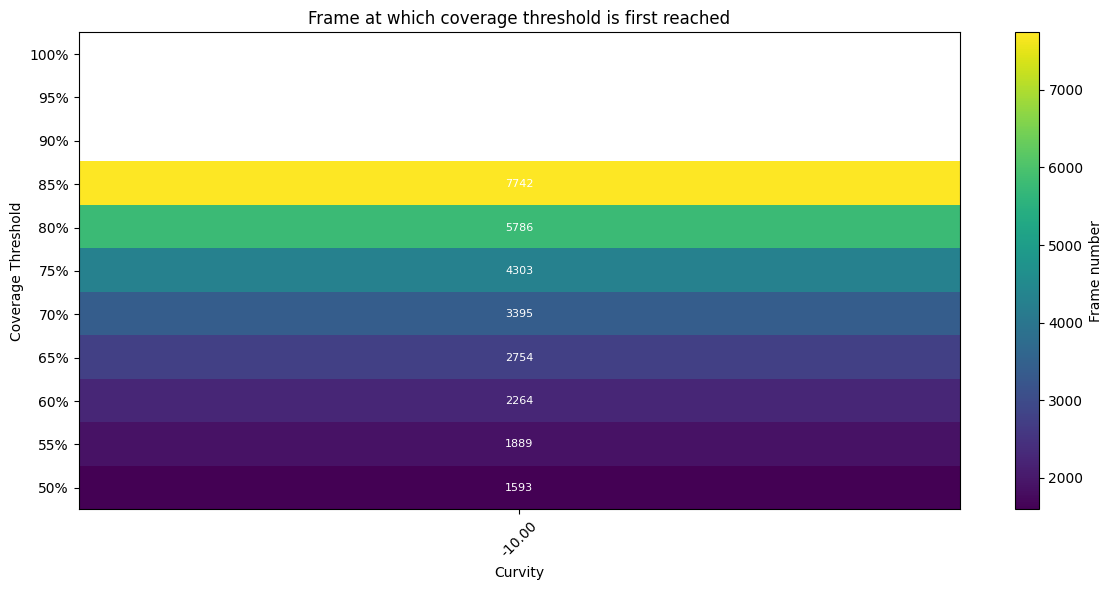

In [24]:
threshold_results = compute_coverage_for_multiple_thresholds(full_df, boxsize, N)
plot_coverage_threshold_heatmap(threshold_results)